In [1]:
import sys
sys.version_info

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)

# Получение данных

In [2]:
import pandas as pd
#информация о магазинах
shop_info = pd.DataFrame(pd.read_pickle(r'shop_info.pkl')).T.drop(['shop_size_coef','shop_id'],axis=1)
shop_info.head()

,apple,banana,pear,orange,lemon
0,825.0,309.0,416.0,522.0,571.0
1,618.0,358.0,459.0,460.0,657.0
2,2144.0,1020.0,1147.0,1660.0,1599.0
3,727.0,349.0,418.0,556.0,437.0
4,667.0,272.0,409.0,556.0,634.0


In [3]:
#коэффициенты взаимосвязи продуктов
p_r = pd.read_pickle(r'product_rels.pkl')
l = list(p_r.values())
d = {'apple': l[0:5], 'banana': l[5:10], 'pear': l[10:15], 'orange':l[15:20], 'lemon':l[20:25]} 
product_rels = pd.DataFrame(d,index=['apple','banana','pear','orange','lemon'])
product_rels

,apple,banana,pear,orange,lemon
apple,0.00,0.15,-0.15,0.17,0.17
banana,0.15,0.00,0.12,0.10,0.10
pear,-0.15,0.12,0.00,0.12,0.12
orange,0.17,0.10,0.12,0.00,-0.19
lemon,0.17,0.10,0.12,-0.19,0.00


In [4]:
#сезонная информация о ценах
prices = pd.read_csv(r'prices.csv').drop(['year_week','start_weekday'],axis=1).head(24)
prices

,price_apple,price_banana,price_pear,price_orange,price_lemon
0,90.0,80.0,130.0,100.0,110.0
1,90.0,80.0,130.0,100.0,110.0
2,90.0,80.0,130.0,100.0,110.0
3,90.0,80.0,130.0,100.0,110.0
4,90.0,80.0,130.0,100.0,110.0
5,80.0,80.0,120.0,95.0,105.0
6,80.0,80.0,120.0,95.0,105.0
7,80.0,80.0,120.0,95.0,105.0
8,80.0,80.0,120.0,95.0,105.0
9,80.0,80.0,120.0,90.0,100.0


# Оптимизация

## Задание № 1

In [5]:
import numpy as np
import pyomo.environ as pyomo
from pyomo.opt import SolverStatus, TerminationCondition

In [6]:
def optimize(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame, limits: dict) -> list:
    
    #создание модели
    model = pyomo.ConcreteModel('model')
    
    #число магазинов
    S = df1.shape[0]
    #число продуктов
    P = df2.shape[0]
    #число недель
    W = df3.shape[0]
    #матрица продаж продуктов в магазинах
    M = df1.values
    #матрица связанных продуктов
    C = df2.values
    #матрица сезонных ожидаемых цен 
    #(транспонирую, чтобы недели стали столбцами, т.к. переменные в целевой функции имеют индекс w для столбцов)
    r_seasonal = df3.values.T
    
    #задание переменных задачи
    model.p = pyomo.Set(initialize=range(P))
    model.w = pyomo.Set(initialize=range(W))
    model.R = pyomo.Set(initialize=model.p*model.w)
    #матрица цен продукта p в неделю w
    model.r = pyomo.Var(model.R, domain=pyomo.NonNegativeReals)
    
    #целевая функция
    F = sum(sum(sum(model.r[p,w] * (M[s,p] * (-(model.r[p,w]/r_seasonal[p,w])**2 - 0.075 * model.r[p,w]/r_seasonal[p,w] + 2.85)/1.775 
                            + sum((r_seasonal[o,w]/model.r[o,w])**2 * C[p,o] * M[s,o] for o in range(P)))\
                            for w in range(W)) for p in range(P)) for s in range(S)) 
    
    model.obj = pyomo.Objective(expr=F, sense=pyomo.maximize)

    # объявление ограничений
    model.c = pyomo.ConstraintList()

    #диапазоны на цены
    for p in range(P):
        for w in range(W):
            model.c.add(model.r[p,w] >= limits['left']*r_seasonal[p,w])
            model.c.add(model.r[p,w] <= limits['right']*r_seasonal[p,w])
    
    solver = pyomo.SolverFactory('ipopt')
    results = solver.solve(model,timelimit=500)

    if (results.solver.status == SolverStatus.ok) or (results.solver.termination_condition == TerminationCondition.optimal):
        print(results)
        print(model.obj())
        return [[model.r[p,w].value for w in range(W)]for p in range(P)]
    else:
        print ("Solver Status:",  result.solver.status)

In [7]:
#коэффициенты ограничивающих диапазонов цен
LIMITS = {
    'right': 1.25,
    'left': 0.75
}

In [8]:
#сохранение оптимальных цен в двумерный массив
optimal_prices = optimize(df1 = shop_info, df2 = product_rels, df3 = prices, limits=LIMITS)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 240
  Number of variables: 120
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.5.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 4.783883571624756
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

718206607.4962041


In [9]:
import random
def get_prices(which):
    P = product_rels.shape[0]
    W = prices.shape[0]
    r_seasonal = prices.values.T

    if(which == 'rand'):
        return [[random.uniform(0.75*r_seasonal[p,w],1.25*r_seasonal[p,w]) for w in range(W)]for p in range(P)]
    elif(which == 'min'):
        return [[0.75*r_seasonal[p,w] for w in range(W)]for p in range(P)]
    elif(which == 'max'):
        return [[1.25*r_seasonal[p,w] for w in range(W)]for p in range(P)]
    elif(which == 'nop'):
        return r_seasonal

In [10]:
random_prices = get_prices('rand')
custom_min_prices = get_prices('min')
custom_max_prices = get_prices('max')
not_optimal_prices = get_prices('nop')

In [11]:
def get_revenue(r: list) -> list:
    S = shop_info.shape[0]
    P = product_rels.shape[0]
    W = prices.shape[0]
    M = shop_info.values
    C = product_rels.values 
    r_seasonal = prices.values.T

    return [sum(sum(r[p][w] * (M[s,p] * (-(r[p][w]/r_seasonal[p,w])**2 - 0.075 * r[p][w]/r_seasonal[p,w] + 2.85)/1.775 
                            + sum((r_seasonal[o,w]/r[o][w])**2 * C[p,o] * M[s,o] for o in range(P))) \
                    for p in range(P))for s in range(S))for w in range(W)]

In [12]:
Revenue_with_opt = get_revenue(optimal_prices)
Revenue_wo_opt = get_revenue(not_optimal_prices)
Revenue_with_min = get_revenue(custom_min_prices)
Revenue_with_max = get_revenue(custom_max_prices)
Revenue_with_rand = get_revenue(random_prices)

In [13]:
#проверка, что сумма выручки по неделям равна общей выручке
sum(Revenue_with_opt)

718206607.4962015

<Axes: title={'center': 'Revenue from all stores'}, xlabel='Week number', ylabel='Expected revenue'>

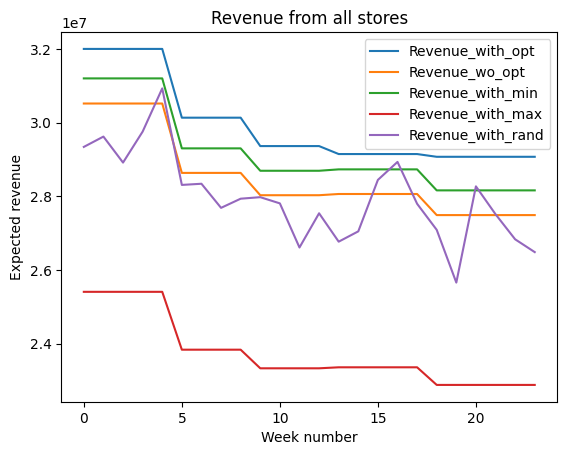

In [14]:
# сравнение выручек при различных подходах к формированию цен
revenues = {'Revenue_with_opt': Revenue_with_opt, 'Revenue_wo_opt': Revenue_wo_opt, 'Revenue_with_min': Revenue_with_min, 
            'Revenue_with_max':Revenue_with_max, 'Revenue_with_rand':Revenue_with_rand}
pd.DataFrame(revenues).plot(xlabel='Week number',ylabel='Expected revenue',title='Revenue from all stores')

<Axes: title={'center': 'Revenue relative increase'}, xlabel='revenues'>

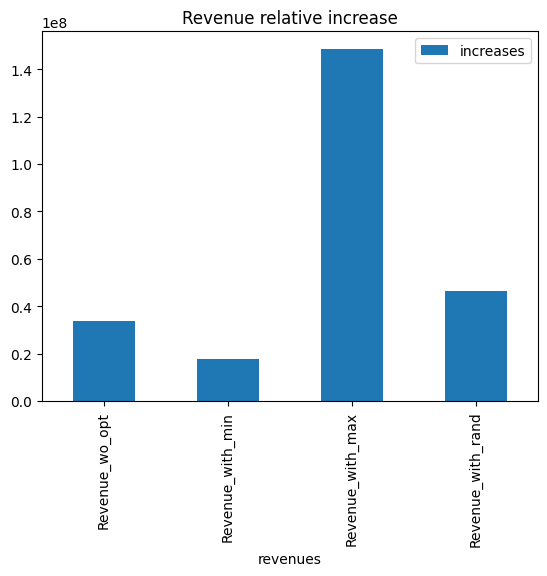

In [15]:
#прирост выручки при оптимальных ценах относительно остальных
pd.DataFrame({'revenues':['Revenue_wo_opt', 'Revenue_with_min', 'Revenue_with_max', 'Revenue_with_rand'], 
              'increases':[sum(Revenue_with_opt)-sum(Revenue_wo_opt), sum(Revenue_with_opt)-sum(Revenue_with_min), 
                           sum(Revenue_with_opt)-sum(Revenue_with_max),sum(Revenue_with_opt)-sum(Revenue_with_rand)]}).plot(kind='bar',
                                                                                                                           x='revenues',
                                                                                                                           y='increases',
                                                                                                                           title='Revenue relative increase')

## Задание №2

In [3]:
def modified_optimize(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame, lim: int) -> list:
    
    #создание модели
    model = pyomo.ConcreteModel('model')
    
    #число магазинов
    S = df1.shape[0]
    #число продуктов
    P = df2.shape[0]
    #число недель
    W = df3.shape[0]
    #матрица продаж продуктов в магазинах
    M = df1.values
    #матрица связанных продуктов
    C = df2.values
    #матрица сезонных ожидаемых цен 
    #(транспонирую, чтобы недели стали столбцами, т.к. переменные в целевой функции имеют индекс w для столбцов)
    r_seasonal = df3.values.T
    
    #задание переменных задачи
    model.p = pyomo.Set(initialize=range(P))
    model.w = pyomo.Set(initialize=range(W))
    model.X = pyomo.Set(initialize=model.p*model.w)
    model.Y = pyomo.Set(initialize=model.p*model.w)
    #матрица коэффициентов для цен продукта p в неделю w
    model.x = pyomo.Var(model.X, domain=pyomo.Reals)
    #матрица наличия акции на продукт p в неделю w
    model.y = pyomo.Var(model.Y, domain=pyomo.Binary, initialize=0)
    
    #целевая функция
    F = sum(sum(sum((model.y[p,w] * model.x[p,w] + r_seasonal[p,w]) * 
                    (M[s,p] * (-((model.y[p,w] * model.x[p,w] + r_seasonal[p,w])/r_seasonal[p,w])**2 
                               - 0.075 * (model.y[p,w] * model.x[p,w] + r_seasonal[p,w])/r_seasonal[p,w] + 2.85)/1.775 
                            + sum((r_seasonal[o,w]/(model.y[o,w] * model.x[o,w] + r_seasonal[o,w]))**2 * C[p,o] * M[s,o] for o in range(P)))\
                            for w in range(W)) for p in range(P)) for s in range(S)) 
    
    model.obj = pyomo.Objective(expr=F, sense=pyomo.maximize)

    # объявление ограничений
    model.c = pyomo.ConstraintList()

    #диапазоны на цены
    for p in range(P):
        for w in range(W):
            model.c.add(model.x[p,w] >= -0.25 * r_seasonal[p,w])
            model.c.add(model.x[p,w] <= 0.25 * r_seasonal[p,w])

    #ограничение количества продуктов в неделю, на которые действует акция
    for w in range(W):
        model.c.add(sum(model.y[p,w] for p in range(P)) <= lim)
        
    solver = pyomo.SolverFactory('bonmin')
    results = solver.solve(model)
    if (results.solver.status == SolverStatus.ok) or (results.solver.termination_condition == TerminationCondition.optimal):
        print(results)
        print(model.obj())
        return [[model.y[p,w].value * model.x[p,w].value + r_seasonal[p,w] for w in range(W)]for p in range(P)]
    else:
        print ("Solver Status:",  result.solver.status)

In [34]:
#сохранение оптимальных цен в двумерный массив
optimal_prices_5 = modified_optimize(df1 = shop_info, df2 = product_rels, df3 = prices, lim = 5)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 240
  Sense: unknown
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 34.50591325759888
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

718520049.163947


In [18]:
optimal_prices_4 = modified_optimize(df1 = shop_info, df2 = product_rels, df3 = prices, lim = 4)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 240
  Sense: unknown
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 133.42660093307495
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

717426644.6643314


In [19]:
optimal_prices_3 = modified_optimize(df1 = shop_info, df2 = product_rels, df3 = prices, lim = 3)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 240
  Sense: unknown
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 413.7634253501892
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

717743957.2176017


In [20]:
optimal_prices_2 = modified_optimize(df1 = shop_info, df2 = product_rels, df3 = prices, lim = 2)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 240
  Sense: unknown
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 68.6159040927887
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

714437331.6951934


In [21]:
optimal_prices_1 = modified_optimize(df1 = shop_info, df2 = product_rels, df3 = prices, lim = 1)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 240
  Sense: unknown
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 391.4016819000244
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

701002996.5113297


In [22]:
optimal_prices_0 = modified_optimize(df1 = shop_info, df2 = product_rels, df3 = prices, lim = 0)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 240
  Sense: unknown
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 75.36323618888855
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

684522522.1499931


In [35]:
Revenue_with_opt_0 = get_revenue(optimal_prices_0)
Revenue_with_opt_1 = get_revenue(optimal_prices_1)
Revenue_with_opt_2 = get_revenue(optimal_prices_2)
Revenue_with_opt_3 = get_revenue(optimal_prices_3)
Revenue_with_opt_4 = get_revenue(optimal_prices_4)
Revenue_with_opt_5 = get_revenue(optimal_prices_5)

<Axes: title={'center': 'Revenue from all stores'}, xlabel='Week number', ylabel='Expected revenue'>

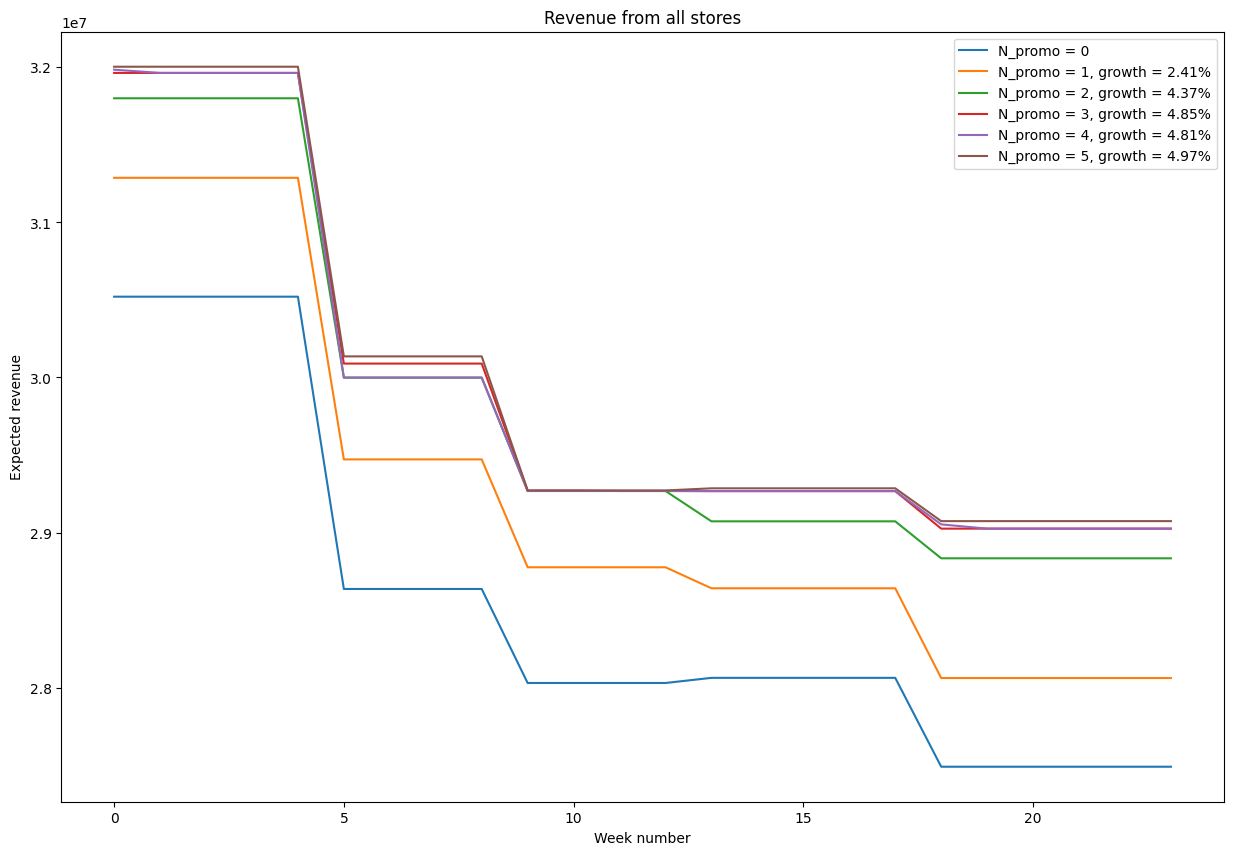

In [36]:
# сравнение выручек при различных количествах акций в неделю
revenues = {'N_promo = 0': Revenue_with_opt_0, 
            'N_promo = 1, growth = %0.2f%%'%((sum(Revenue_with_opt_1) - sum(Revenue_with_opt_0))*100/sum(Revenue_with_opt_0)): Revenue_with_opt_1,
            'N_promo = 2, growth = %0.2f%%'%((sum(Revenue_with_opt_2) - sum(Revenue_with_opt_0))*100/sum(Revenue_with_opt_0)): Revenue_with_opt_2,
            'N_promo = 3, growth = %0.2f%%'%((sum(Revenue_with_opt_3) - sum(Revenue_with_opt_0))*100/sum(Revenue_with_opt_0)): Revenue_with_opt_3,
            'N_promo = 4, growth = %0.2f%%'%((sum(Revenue_with_opt_4) - sum(Revenue_with_opt_0))*100/sum(Revenue_with_opt_0)): Revenue_with_opt_4,
            'N_promo = 5, growth = %0.2f%%'%((sum(Revenue_with_opt_5) - sum(Revenue_with_opt_0))*100/sum(Revenue_with_opt_0)): Revenue_with_opt_5}
pd.DataFrame(revenues).plot(xlabel='Week number',ylabel='Expected revenue',title='Revenue from all stores',figsize=(15,10))